In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import base
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [102]:
#Load data
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/CSE291/"
dataset_df = pd.read_csv(dataset_dir + "covid19_sera_merged.csv")
dataset_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,maestro_column_unmod,maestro_column_variant,patient_id,label,y_covid,y_severe_type,Patient ID a,Metabolomics ID e,Metabolites,(14 or 15)-methylpalmitate (a17:0 or i17:0),...,variant_ccms_row_101452,variant_ccms_row_101453,variant_ccms_row_101454,variant_ccms_row_101455,variant_ccms_row_101456,variant_ccms_row_101457,variant_ccms_row_101458,variant_ccms_row_101459,variant_ccms_row_101460,variant_ccms_row_101461
0,_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for...,_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for...,HC1,Healthy,0,0,HC1,jkdz1,jkdz1,7439425.0,...,0.0,1.958825,0.00000,0.000000,1.174198,0.0,0.0,0.0,0.370040,0.0
1,_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_f...,_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_f...,HC10,Healthy,0,0,HC10,jkdz10,jkdz10,16636076.0,...,0.0,2.544654,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_f...,_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_f...,HC12,Healthy,0,0,HC12,jkdz12,jkdz12,9140857.0,...,0.0,0.913199,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
3,_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_f...,_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_f...,HC13,Healthy,0,0,HC13,jkdz13,jkdz13,7863659.5,...,0.0,1.035449,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,_dyn_#Healthy.HC17.Healthy..HC17.1_intensity_f...,_dyn_#Healthy.HC17.Healthy..HC17.1_intensity_f...,HC17,Healthy,0,0,HC17,jkdz17,jkdz17,7996507.5,...,0.0,0.110892,0.81455,0.863862,0.000000,0.0,0.0,0.0,0.791905,0.0


In [103]:
#Variant features bound
variant_bounds = [102411, 203871]
unmod_bounds = [950, 102411]

In [104]:
#Preprocess function
def preprocess_dataset(dataset_df):
    dataset_df = dataset_df.fillna(0)
    return dataset_df

In [105]:
#Function which splits the input dataset
def get_train_test_split(dataset_df, split_ratio = 0.2):
    train_df, test_df, y_train, y_test = train_test_split(dataset_df, dataset_df['y_covid'], test_size=0.2, stratify = dataset_df['y_covid'])
    return train_df, test_df, y_train, y_test

In [106]:
#Filter out columns based on certain metrics
def select_feature_columns_ind_metrics(feature_type = 'variant', column_stats = None, missing_ratio_threshold = None, kendall_corr_threshold = None):
    if column_stats is None:
        return None
    if missing_ratio_threshold:
        # print ("Updating column stats")
        column_stats = column_stats[column_stats['missing'] < missing_ratio_threshold]
        # print ("Done computing column stats")
    if kendall_corr_threshold:
        column_stats = column_stats[column_stats['kendall'] > kendall_corr_threshold]
    selected_indices = list(column_stats.index)
    if feature_type == 'variant':
        return [item for item in selected_indices if item >= variant_bounds[0] and item < variant_bounds[1]]
    else:
        return [item for item in selected_indices if item >= unmod_bounds[0] and item < unmod_bounds[1]]
    return selected_indices

In [107]:
#Compute missing value ratios (considering 0 to be a missing feature)
def compute_missing_values_ratio(col_values):
    return len([item for item in col_values if item == 0])/len(col_values)

In [108]:
#Compute kendall correlation (between feature and target)
def compute_kendall_correlation(df, col_index, target):
    val = df[df.columns[col_index]].corr(target, method = 'kendall')
    return val

In [109]:
#Compute stats corresponding to each column in the dataframe
def generate_column_stats_df(dataset_df):
    col_stats = dict()
    for col_index in range(dataset_df.shape[1]):
        col_values = list(dataset_df[dataset_df.columns[col_index]])
        col_stats[col_index] = {'missing': compute_missing_values_ratio(col_values), 'kendall': abs(compute_kendall_correlation(dataset_df, col_index, dataset_df['y_covid']))}
    colstatsdf = pd.DataFrame(col_stats).transpose()
    return colstatsdf

In [110]:
def run_logistic_regression(parameters, train, y_train, test, y_test, grid_search_obj = None):
    model = None
    if grid_search_obj:
        model = base.clone(grid_search_obj.base_estimator_)
    else:
        model = GridSearchCV(LogisticRegression(), parameters)
    model.fit(train, y_train)
    score = model.score(test, y_test)
    print ("Test Accuracy - {}".format(score))
    if not grid_search_obj:
        return score, model.best_estimator_
    else:
        return score, model

In [111]:
def get_mean_accuracies(col_indices, dataset, split_count = 5, split_ratio = 0.2, parameters = None):
    splits = list()
    for index in range(split_count):
        train_df, test_df, y_train, y_test = get_train_test_split(dataset_df, split_ratio)
        splits.append([train_df, test_df, y_train, y_test])
    if not parameters:
        parameters = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500], 'solver': ['liblinear']}
    accuracies = list()
    models = list()
    for index, (train_df, test_df, y_train, y_test) in enumerate(splits):
        print ("Split count {}".format(index))
        print ("Covid positive train_df - {}".format(train_df[train_df['y_covid'] == 1].shape[0]))
        print ("Covid negative train_df - {}".format(train_df[train_df['y_covid'] == 0].shape[0]))
        print ("Covid positive test_df - {}".format(test_df[test_df['y_covid'] == 1].shape[0]))
        print ("Covid negative test_df - {}".format(test_df[test_df['y_covid'] == 0].shape[0]))
        train_df = train_df.iloc[:, col_indices]
        test_df = test_df.iloc[:, col_indices]
        print ("Train DF shape - {} | Test DF shape - {}".format(train_df.shape, test_df.shape))
        score, model = run_logistic_regression(parameters, train_df, y_train, test_df, y_test)
        print ("Split count {} | Accuracy - {}\n".format(index, score))
        accuracies.append(score)
        models.append(model)
    print ("Mean accuracy - ", sum(accuracies)/float(len(accuracies)))
    return models

In [112]:
dataset_df = preprocess_dataset(dataset_df)

In [113]:
columnstats = generate_column_stats_df(dataset_df)

In [114]:
selected_col_indices = select_feature_columns_ind_metrics(feature_type = 'variant', column_stats = columnstats, missing_ratio_threshold = 0.4)

In [115]:
# parameters = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'max_iter': [500], 'solver': ['liblinear']}

In [116]:
# models = get_mean_accuracies(col_indices = selected_col_indices, dataset = dataset_df, split_count = 5, parameters = parameters)

In [117]:
parameters2 = {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1], 'max_iter': [250], 'solver': ['liblinear']}

In [118]:
print ("Count of NaN values - {}".format(dataset_df.iloc[:].isnull().sum().sum()))

Count of NaN values - 0


In [119]:
models2 = get_mean_accuracies(col_indices = selected_col_indices, dataset = dataset_df, split_count = 5, parameters = parameters2)

Split count 0
Covid positive train_df - 33
Covid negative train_df - 33
Covid positive test_df - 8
Covid negative test_df - 9
Train DF shape - (66, 29275) | Test DF shape - (17, 29275)
Test Accuracy - 1.0
Split count 0 | Accuracy - 1.0

Split count 1
Covid positive train_df - 33
Covid negative train_df - 33
Covid positive test_df - 8
Covid negative test_df - 9
Train DF shape - (66, 29275) | Test DF shape - (17, 29275)
Test Accuracy - 1.0
Split count 1 | Accuracy - 1.0

Split count 2
Covid positive train_df - 33
Covid negative train_df - 33
Covid positive test_df - 8
Covid negative test_df - 9
Train DF shape - (66, 29275) | Test DF shape - (17, 29275)
Test Accuracy - 1.0
Split count 2 | Accuracy - 1.0

Split count 3
Covid positive train_df - 33
Covid negative train_df - 33
Covid positive test_df - 8
Covid negative test_df - 9
Train DF shape - (66, 29275) | Test DF shape - (17, 29275)
Test Accuracy - 1.0
Split count 3 | Accuracy - 1.0

Split count 4
Covid positive train_df - 33
Covid neg

In [120]:
#Map model indices to col indices of dataset_df
def get_dataset_indices(model_indices, selected_col_indices):
  # print ("Min of model indices - ", min(model_indices))
  # print ("Max of model indices - ", max(model_indices))
    return [selected_col_indices[index] for index in model_indices]

In [121]:
#Get feature importances by absolute values of the coefficients
def regression_coefficient_argsort(models, selected_col_indices):
    feature_importances = list()
    for model in models:
        # print ("Shape coef - {}".format(abs(model.coef_).T[:, 0].shape))
        sorted_feature_importances = get_dataset_indices(list(np.argsort(abs(model.coef_).T[:, 0])), selected_col_indices)
        feature_importances.append(sorted_feature_importances)
    return feature_importances

In [122]:
feature_importances_per_model = regression_coefficient_argsort(models2, selected_col_indices)

In [123]:
def get_top_n_features_models(models2, n = 5):
    top_n_features_per_model = list()
    for index, model in enumerate(models2):
        model_top_5 = [dataset_df.columns[i] for i in feature_importances_per_model[index][(-1 * n):]]
        print ("Top 5 features by coefficient value for model {} | {}".format(index, ", ".join(model_top_5)))
        top_n_features_per_model.append(model_top_5)
    return top_n_features_per_model

In [124]:
top_5_features_per_model = get_top_n_features_models(models2, n = 5)

Top 5 features by coefficient value for model 0 | variant_ccms_row_42727, variant_ccms_row_53107, variant_ccms_row_58283, variant_ccms_row_58286, variant_ccms_row_70224
Top 5 features by coefficient value for model 1 | variant_ccms_row_58286, variant_ccms_row_53107, variant_ccms_row_42727, variant_ccms_row_58283, variant_ccms_row_70224
Top 5 features by coefficient value for model 2 | variant_ccms_row_10605, variant_ccms_row_42727, variant_ccms_row_70224, variant_ccms_row_53107, variant_ccms_row_58283
Top 5 features by coefficient value for model 3 | variant_ccms_row_42727, variant_ccms_row_58286, variant_ccms_row_53107, variant_ccms_row_58283, variant_ccms_row_70224
Top 5 features by coefficient value for model 4 | variant_ccms_row_57428, variant_ccms_row_48133, variant_ccms_row_53107, variant_ccms_row_70224, variant_ccms_row_58283


In [125]:
def feature_score(models_top_n_features, disregard_rank = True):
    feature_importance = dict()
    for model_top_n in models_top_n_features:
        for index, feature in enumerate(model_top_n):
            if feature not in feature_importance.keys():
                feature_importance[feature] = 0
            if disregard_rank:
                feature_importance[feature] += 1
            else:
                feature_importance[feature] += (len(model_top_n) - index)
    return feature_importance

In [126]:
feature_importance = feature_score(top_5_features_per_model)

In [127]:
pd.Series(feature_importance).sort_values(ascending = False)

variant_ccms_row_53107    5
variant_ccms_row_58283    5
variant_ccms_row_70224    5
variant_ccms_row_42727    4
variant_ccms_row_58286    3
variant_ccms_row_10605    1
variant_ccms_row_57428    1
variant_ccms_row_48133    1
dtype: int64

In [128]:
adaptive_feature_importance = feature_score(top_5_features_per_model, disregard_rank = False)

In [129]:
adaptive_feature_importance = pd.Series(adaptive_feature_importance).sort_values(ascending = False)

In [132]:
def plot_histograms(feature_list, targets, remove_zero = True):
    covid_positive = [item for index, item in enumerate(feature_list) if targets[index] == 1 and ((not remove_zero) or (remove_zero and item != 0))]
    covid_negative = [item for index, item in enumerate(feature_list) if targets[index] == 0 and ((not remove_zero) or (remove_zero and item != 0))]
    bins = np.linspace(0, 4, 100)
    plt.hist(covid_positive, bins, alpha=0.5, label='positive')
    plt.hist(covid_negative, bins, alpha=0.5, label='negative')
    plt.legend(loc='upper right')
    plt.show()

Class separation for feature variant_ccms_row_42727:


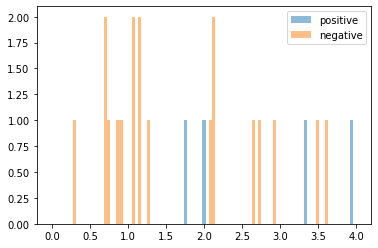

Class separation for feature variant_ccms_row_53107:


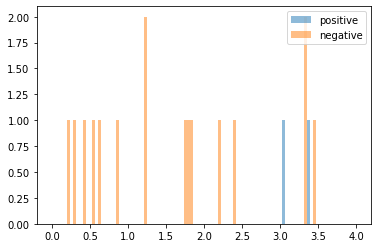

Class separation for feature variant_ccms_row_58286:


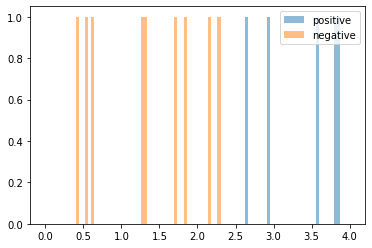

Class separation for feature variant_ccms_row_58283:


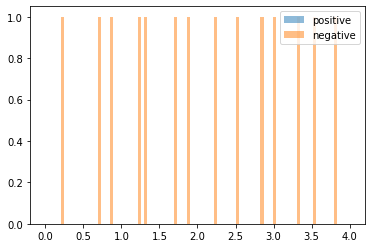

Class separation for feature variant_ccms_row_70224:


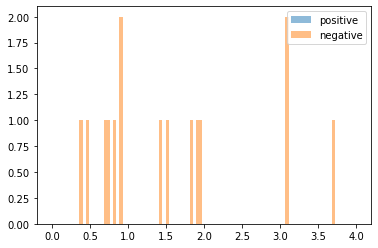

Class separation for feature variant_ccms_row_10605:


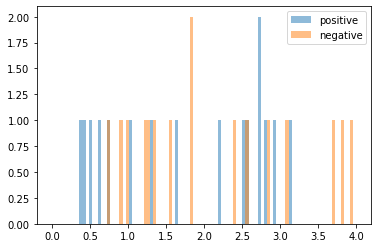

Class separation for feature variant_ccms_row_57428:


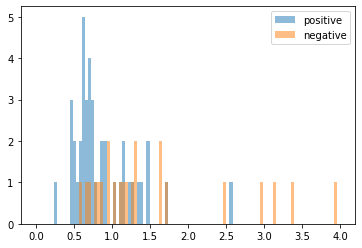

Class separation for feature variant_ccms_row_48133:


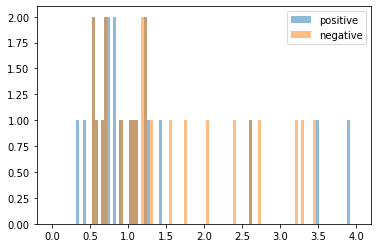

In [133]:
for feature in adaptive_feature_importance.index:
    print ("Class separation for feature {}:".format(feature))
    plot_histograms(dataset_df[feature], dataset_df['y_covid'])